In [2]:
# Cargamos los módulos necesarios
#--------------------------------
import cv2 as cv
import numpy as np

### Definimos las funciones que vamos a necesitar

- __deskew:__ Endereza los dígitos basados en los momentos calculados sobre cada caracter
- __hog:__ Descriptor basado en histograma de gradientes

Links de interés:

1. https://www.wikiwand.com/en/Skewness
2. https://www.wikiwand.com/en/Shear_matrix

En la siguiente imagen del tutorial de OpenCV puede verse qué es lo que se intenta hacer:

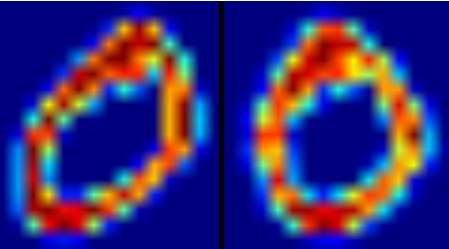

En cuanto a los momentos:

- $M_{0,0}$: Área (cantidad de píxels)
- $M_{1,0}$ y $M_{0,1}$ cuando se los normaliza por $M_{0,0}$ son las posiciones del centro de masa en $x$ e $y$. Es decir $\bar{x}$, $\bar{y}$.
- Luego para los momentos de mayor orden:
    - $\mu_{2,0}'=\frac{M_{2,0}}{M_{0,0}}-\bar{x}^2$
    - $\mu_{1,1}'=\frac{M_{1,1}}{M_{0,0}}-\bar{x}\bar{y}$
    - $\mu_{0,2}'=\frac{M_{0,2}}{M_{0,0}}-\bar{y}^2$ <br>
    A partir de estos la matriz de covarianza del objeto resulta:<br>
    - $cov(Objeto) = \begin{bmatrix} \mu_{2,0}' & \mu_{1,1}' \\ \mu_{1,1}' & \mu_{0,2}' \end{bmatrix}$
     

In [3]:
SZ=20                                                      # Tamaño de la imagen en píxels
bin_n = 16                                                 # Numero de bins
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR         # Flags para la transformación afín

# Definimos una función para "enderezar" los caracteres
#------------------------------------------------------
def deskew(img):
    m = cv.moments(img)                                    # Calcula los momentos (hasta el 3er orden)
    if abs(m['mu02']) < 1e-2:                              # mu02: skewness en el eje x
        return img.copy()
    skew = m['mu11']/m['mu02']                             # mu11: varianza
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])   # Armamos la matriz para "enderezar" a través de la transformación afín
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags) # Aplico una transformación afín
    return img

# Descriptor HoG (Histogram of Gradients)
#----------------------------------------
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)                    # Derivada en x
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)                    # Derivada en y
    mag, ang = cv.cartToPolar(gx, gy)                      # Calculamos módulo y ángulo (en radianes) 
    bins = np.int32(bin_n*ang/(2*np.pi))                   # Cuantizamos el espacio de ángulos en 16 bins
    # Partimos la imagen en 4 cuartos para calcularles el histograma.
    # OJO: sabemos que las imágenes son de 20x20 píxels, por eso está harcodeado el 10
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    # Calculamos los histogramas de cada bloque (son histogramas de ángulo con la magnitud como pesos)
    # Tienen a su vez 16 bins cada uno, por lo que el descriptor final de la imagen es de 64 bits
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)                                # Finalmente hist es un vector de 64 bit
    return hist

### Leemos y preparamos los datos

De la imagen original se parte en cada caracter y luego se eligen con permutaciones aleatorias los datos de entrenamiento y los de testeo

In [5]:
# Leemos la imagen de números (de igual manera que hacíamos en kNN)
#------------------------------------------------------------------
img = cv.imread('digits.png',0)
if img is None:
    raise Exception("Necesitamos la imagen para procesar!")

# Partimos la imagen completa en las 100x50 subimágenes de 20x20 píxels
#----------------------------------------------------------------------
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]    

# Dividimos en datos de entranamiento y de testeo
#------------------------------------------------
percentage = 0.7
n = 100                                     # Los caracteres vienen en una imagen de 100 x 50
a = int(percentage * n)    
idxs_permutados = np.random.permutation(n)
train_idxs = idxs_permutados[0:a]           # Obtenemos los ids para el train data
test_idxs = idxs_permutados[a:n]            # Obtenemos los ids para el test data

train_cells = [ np.array(i)[train_idxs] for i in cells]
test_cells = [ np.array(i)[test_idxs] for i in cells]

# Enderezamos y calculamos los descriptores HoG
#----------------------------------------------
deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]

# Le damos forma al train data como los vectores de 64 caracteristicas de los descriptores HoG y
# asignamos las salidas según corresponda (en este caso es fácil porque están ordenados)
#---------------------------------------------------------------------------------------
trainData = np.float32(hogdata).reshape(-1,64)
responses_train = np.repeat(np.arange(10),5*a)[:,np.newaxis]     # train labels
responses_test = np.repeat(np.arange(10),5*(n-a))[:,np.newaxis]  # test labels
print(trainData.shape)
print(responses_test.shape)

(3500, 64)
(1500, 1)


### Entrenamos la SVM y verificamos contra el test set

El costo (C) y el Gamma son los hiperparámetros que deciden el desempeño del modelo SVM. Como en todo modelo de machine learning debe haber un buen equilibrio entre la varianza y el sesgo (bias). (Esta selección es a la vez una ciencia y un arte)

Para el algoritmo SVM, un valor alto de Gamma conlleva a una mayor precisión pero resultados más sesgados y viceversa. De manera similar, un valor alto del parámetro de costo (C) indica una precisión deficiente pero un sesgo bajo y viceversa.

Esto puede resumirse en la siguiente tabla:

<br>

 |              | Gamma grande  | Gamma chico | C grande  | C chico |
 | ------------ | ------------- | ----------- | --------- | ------- |
 | Varianza     | Baja          | Alta        | Alta      | Baja    |
 | Sesgo (Bias) | Alto          | Bajo        | Bajo      | Alto    |

<br>
El arte consiste en elegir un modelo con varianza y sesgo óptimos y por lo tanto, elegir los valores de C y Gamma en consecuencia.

<br>

C es el costo de un error de clasificación. Un C grande da un sesgo bajo y una alta varianza. Bajo sesgo porque penaliza mucho el costo de la clasificación incorrecta. Un C pequeño da un mayor sesgo y una menor varianza.

Gamma es el parámetro de un núcleo gaussiano (para manejar la clasificación no lineal). Consideremos el siguiente ejemplo:

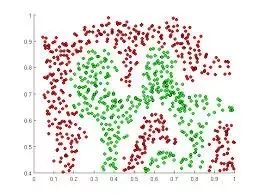

No se pueden separar linealmente en 2D, por lo que desea transformarlos a una dimensión superior en la que se puedan separar linealmente. Imaginemos "elevar" los puntos verdes, luego pueden separarse de los puntos rojos con un plano (hiperplano)

Para "elevar" los puntos podríamos usar el kernel RBF, en este caso gamma controla la forma de los "picos" donde se elevan los puntos. Una gamma pequeño le da una protuberancia puntiaguda en las dimensiones más altas, un gamma grande le da una protuberancia más suave y amplia.

Por lo tanto, un gamma pequeño le dará un sesgo bajo y una varianza alta, mientras que una gamma grande le dará un sesgo más alto y una varianza baja.

Los valores óptimos de C y Gamma se podrían encontrarse utilizando métodos como Gridsearch o métodos de optimización como - PSO, Algoritmos genéticos, etc.

In [6]:
# Inicializamos el clasificador SVM
#----------------------------------
svm = cv.ml.SVM_create()            # Creamos la intancia de la SVM
svm.setKernel(cv.ml.SVM_LINEAR)     # El Kernel lineal implica sin mapeo (producto interno de parámetros x^tx)
svm.setType(cv.ml.SVM_C_SVC)        # Este tipo de SVM contempla separación imperfecta con parámetro de pensalidad C
svm.setC(2.67)                      # Parámetro de penalidad sobre las muestras dentro del margen
svm.setGamma(5.383)                 # Parámetro utilizado en los Kernel Poly, RBF, Sigmoid, Chi2

# Entrenamos el modelo con el train set
#--------------------------------------
svm.train(trainData, cv.ml.ROW_SAMPLE, responses_train)
svm.save('svm_data.dat')

# Testeamos el modelo contra las muestras del test set
#-----------------------------------------------------
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

# Calculamos el porcentaje de aciertos
#-------------------------------------
mask = result==responses_test
correct = np.count_nonzero(mask)
print('Accuracy: {:.3f} %'.format(correct*100.0/result.size))

Accuracy: 93.933 %
